<div class="alert alert-block alert-info"> <b>Dependencies</b> </div>


In [ ]:
#Importing necessary libraries

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Conv1D , MaxPooling1D , LSTM, TimeDistributed, Flatten, GRU, RepeatVector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff


from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [ ]:
# This is used for displaying maximum number of columns

pd.set_option('display.max_columns', None)

In [ ]:
# Loading the dataset

train = pd.read_csv('/content/drive/MyDrive/train.csv (1)/train.csv', parse_dates=['date'])

In [ ]:
train.shape

(913000, 4)

In [ ]:
#Time period of the train dataset

print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


<div class="alert alert-block alert-info"> <b> Data Cleaning and Pre-processing</b> </div>


In [ ]:
#adding features to the training dataset to granular level
train['date']=pd.to_datetime(train['date'], infer_datetime_format=True)
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.week
train['dayofweek'] = train['date'].dt.dayofweek
train['weekday'] = train['date'].dt.weekday
train['dayofyear'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter
train['daily_avg']=train.groupby(['item','store','dayofweek'])['sales'].transform('mean')
train['monthly_avg']=train.groupby(['item','store','month'])['sales'].transform('mean')
train["mean_store_item_month"] = train.groupby(['month',"item","store"])["sales"].transform("mean")
daily_avg=train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
monthly_avg=train.groupby(['item','store','month'])['sales'].mean().reset_index()
mean_store_item_month = train.groupby(['month','item','store'])['sales'].mean().reset_index()
train.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
dtype: object

1. Data Types: The DataFrame contains columns with various data types.
2. Date: A datetime column named "date" in datetime64[ns] format.
Store, Item, Sales: These are integer columns representing store ID, item ID, and sales respectively.
3. Time Components: Columns representing different time components such as year, month, day, week, dayofweek, weekday, dayofyear, and quarter.
4. Averages: Columns like daily_avg, monthly_avg, and mean_store_item_month represent various averages, likely calculated from the sales data.
5. Data Type Summary: The dtype: object indicates that the summary is for the data types of the columns.

In [ ]:
#making a copy of the training data to use to for further processing
train_v2 = train.copy()
train.head()

,date,store,item,sales,year,month,day,week,dayofweek,weekday,dayofyear,quarter,daily_avg,monthly_avg,mean_store_item_month
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,1,18.168582,13.709677,13.709677
1,2013-01-02,1,1,11,2013,1,2,1,2,2,2,1,18.793103,13.709677,13.709677
2,2013-01-03,1,1,14,2013,1,3,1,3,3,3,1,19.452107,13.709677,13.709677
3,2013-01-04,1,1,13,2013,1,4,1,4,4,4,1,21.015326,13.709677,13.709677
4,2013-01-05,1,1,10,2013,1,5,1,5,5,5,1,22.973180,13.709677,13.709677


In [ ]:
# Create New DataFrame of Specific column by DataFrame.assign() method.
sales_df = pd.DataFrame().assign(sales=train_v2['sales'])

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
    return agg

#introducing look-back feature
window = 29
lag = 30
sales_series = series_to_supervised(sales_df, window=window, lag=lag)
sales_series = sales_series.drop('sales(t)', axis=1)
sales_series = sales_series.drop('sales(t+30)', axis=1)
sales_series.shape

(913000, 29)

1. DataFrame Creation: A new DataFrame named sales_df is created using the pd.DataFrame().assign() method. It contains a single column named "sales", extracted from another DataFrame train_v2.

2. Series to Supervised Transformation: The series_to_supervised function is defined to transform the sales_df data into a supervised learning format suitable for time series forecasting.

3. Look-back Feature: The function introduces a look-back feature by shifting the data to create sequences of past observations (window) and a lag for future predictions (lag).

4. Concatenation: The function concatenates the shifted data along with the original data to create the final aggregated DataFrame.

5. Column Naming: Column names are generated to represent each time step, including both past and future observations.

6. Final DataFrame Shape: After transformation, the sales_series DataFrame has a shape of (913000, 29), indicating 913,000 samples and 29 features for the previous 29 time steps.

In [ ]:
train_v2.shape

(913000, 15)

In [ ]:
#merging training dataset with the sales_series created above with the look-back feature
train_v2 = pd.concat([train_v2, sales_series], axis=1)
#replacing NaN values with 0
train_v2 = train_v2.replace(np.nan,0)
train_v2.head()

,date,store,item,sales,year,month,day,week,dayofweek,weekday,dayofyear,quarter,daily_avg,monthly_avg,mean_store_item_month,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1)
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,1,18.168582,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,1,1,11,2013,1,2,1,2,2,2,1,18.793103,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2,2013-01-03,1,1,14,2013,1,3,1,3,3,3,1,19.452107,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0
3,2013-01-04,1,1,13,2013,1,4,1,4,4,4,1,21.015326,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,14.0
4,2013-01-05,1,1,10,2013,1,5,1,5,5,5,1,22.973180,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,14.0,13.0


In [ ]:
#Displaying the datatypes of the features present in train_v2 dataframe

train_v2.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
sales(t-29)                     float64
sales(t-28)                     float64
sales(t-27)                     float64
sales(t-26)                     float64
sales(t-25)                     float64
sales(t-24)                     float64
sales(t-23)                     float64
sales(t-22)                     float64
sales(t-21)                     float64
sales(t-20)                     float64


In [ ]:
#feature set specific to machine learning models
train['is_month_start'] = train['date'].dt.is_month_start
train['is_month_end'] =train['date'].dt.is_month_end
train['is_quarter_start'] = train['date'].dt.is_quarter_start
train['is_quarter_end'] = train['date'].dt.is_quarter_end
train['is_year_start'] = train['date'].dt.is_year_start
train['is_year_end'] = train['date'].dt.is_year_end

#Create mask for boolean values for train dataset
train['is_month_start'] = train['is_month_start'].replace({True: 1, False: 0})
train['is_month_end'] = train['is_month_end'].replace({True: 1, False: 0})
train['is_quarter_start'] = train['is_quarter_start'].replace({True: 1, False: 0})
train['is_quarter_end'] = train['is_quarter_end'].replace({True: 1, False: 0})
train['is_year_start'] = train['is_year_start'].replace({True: 1, False: 0})
train['is_year_end'] = train['is_year_end'].replace({True: 1, False: 0})

#convert float to int
train['daily_avg']=train['daily_avg'].astype(np.int64)
train['monthly_avg']=train['monthly_avg'].astype(np.int64)
train['mean_store_item_month']=train['mean_store_item_month'].astype(np.int64)
train.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
dtype: object

1. Feature Engineering: Boolean features are created based on specific datetime properties such as whether it's the start or end of a month, quarter, or year. These features capture temporal patterns that could be relevant for predictive modeling.

2. Mask Creation: Initially, the boolean values in the new features are represented as True or False. They are then converted to binary integers (0 for False, 1 for True) using the replace() method, creating a binary mask suitable for machine learning algorithms.

3. Conversion to Integer: Certain columns (daily_avg, monthly_avg, mean_store_item_month) are converted from float to integer data types using astype(np.int64). This conversion is often done to ensure compatibility with machine learning algorithms, as they typically work with numerical data in integer or floating-point format.

4. Data Type Check: Finally, the data types of the DataFrame columns are printed to confirm the changes made in the previous steps.

<div class="alert alert-block alert-info"> <b>Exploratory Data Analysis</b> </div>


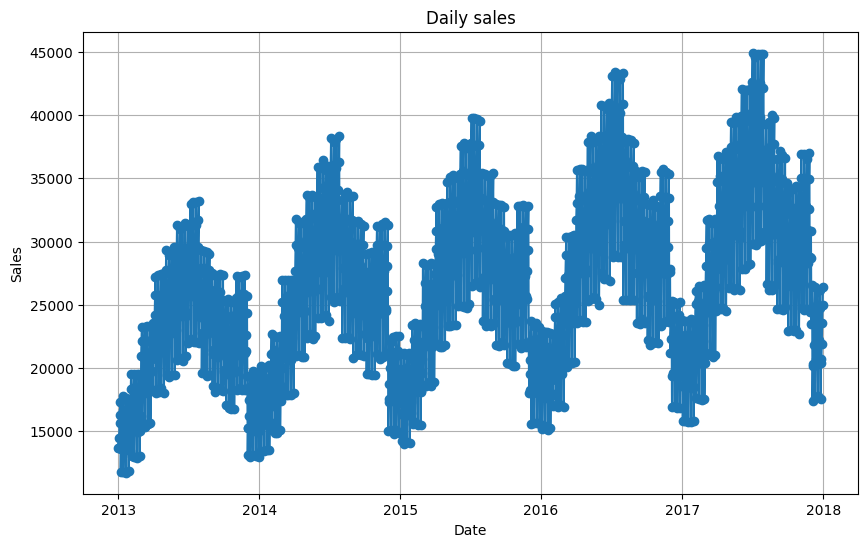

In [ ]:
import matplotlib.pyplot as plt

# Plotting overall daily sales using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], marker='o', linestyle='-')
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


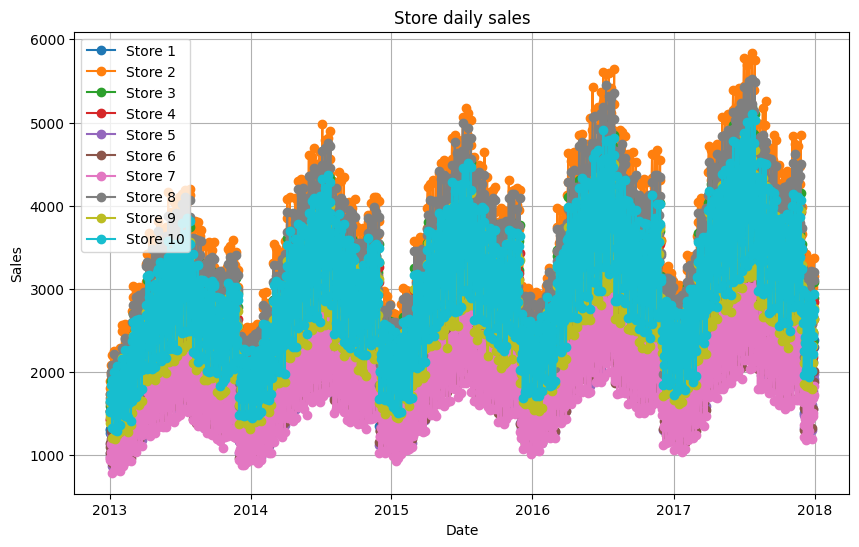

In [ ]:
import matplotlib.pyplot as plt

# Plotting store daily sales using matplotlib
plt.figure(figsize=(10, 6))
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[store_daily_sales['store'] == store]
    plt.plot(current_store_daily_sales['date'], current_store_daily_sales['sales'], label='Store {}'.format(store), marker='o')

plt.title('Store daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


We observe that sales for each store consistently peak in the middle of the year, which may coincide with various festivals or events. Additionally, there's a noticeable upward trend in peak sales values from 2013 to 2018, indicating a year-over-year increase in sales.

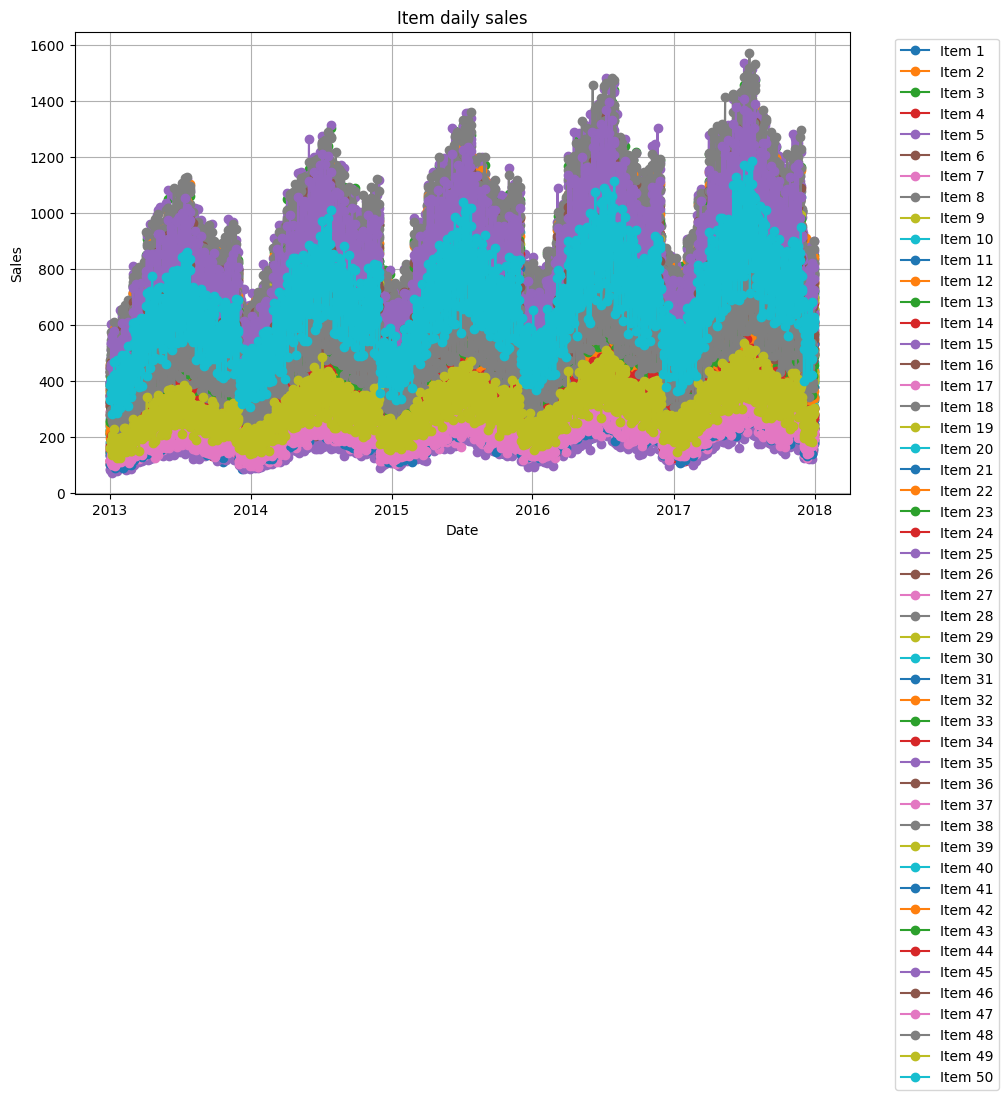

In [ ]:
import matplotlib.pyplot as plt

# Plotting item daily sales using matplotlib
plt.figure(figsize=(10, 6))
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[item_daily_sales['item'] == item]
    plt.plot(current_item_daily_sales['date'], current_item_daily_sales['sales'], label='Item {}'.format(item), marker='o')

plt.title('Item daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Shift legend horizontally
plt.grid(True)
plt.show()


We observe that sales for every item in each store consistently peak in the middle of the year, potentially aligning with various festivals or events. Additionally, there's a noticeable upward trend in peak sales values from 2013 to 2018 for each item, indicating a year-over-year increase in sales across the entire product range within the store

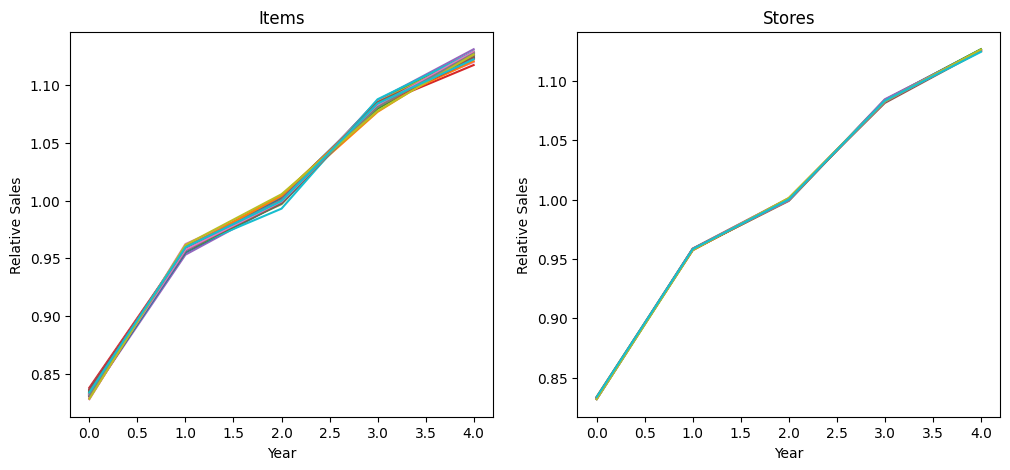

All items and stores follow a similar growth in sales over the years.


In [ ]:
#plotting sales over years
agg_year_item = pd.pivot_table(train, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores follow a similar growth in sales over the years.")

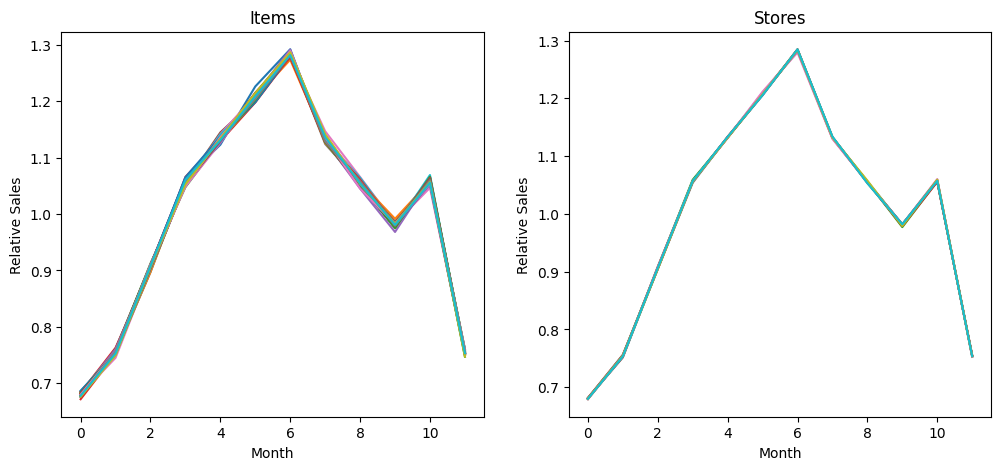

All items and stores share a common pattern in sales over the months as well.


In [ ]:
#Plotting items and stores relative sales over months
agg_month_item = pd.pivot_table(train, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores share a common pattern in sales over the months as well.")

The sales of different products from different store is low at the beginning and the end of the year whereas at it's peak during the middle of the year.

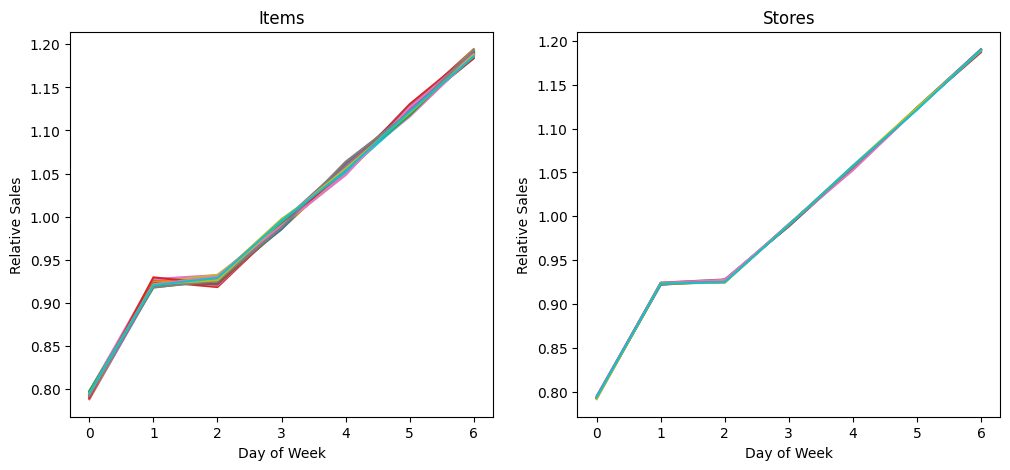

All items and stores also seem to share a common pattern in sales over the days of the week as well.


In [ ]:
#Plotting relative sales of items and stores over the day of week
agg_dow_item = pd.pivot_table(train, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(train, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores also seem to share a common pattern in sales over the days of the week as well.")

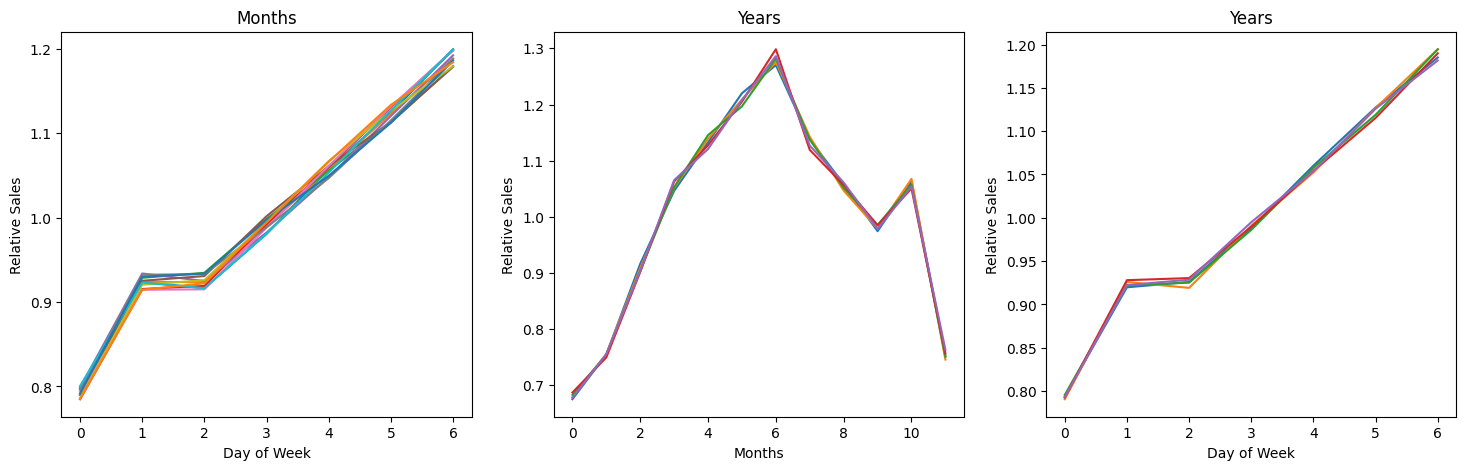

In [ ]:
#checking for degeneracies in the data which can lead to missing important trends in complex datasets
agg_dow_month = pd.pivot_table(train, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(train, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(train, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()


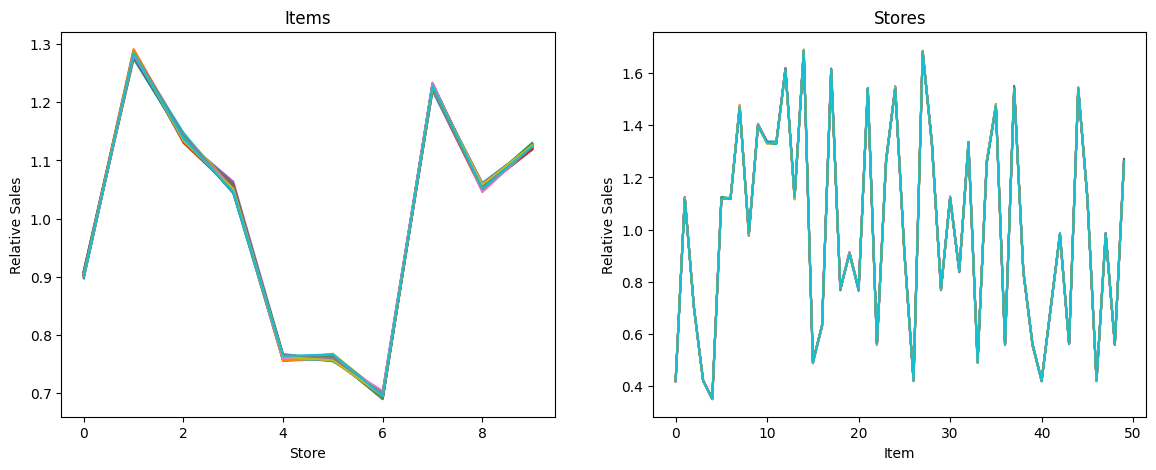

In [ ]:
#checking for degeneracies in the data - items and sales which can lead to missing important trends in complex datasets
agg_store_item = pd.pivot_table(train, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()


1. In the data visualization, store-1 emerges with the highest sales of items, closely trailed by store-7, while store-6 exhibits the lowest sales among all available stores.
2. Sales across all items exhibit considerable diversity.



<div class="alert alert-block alert-info"> <b>Train, Validation and Test Data Preparation</b> </div>

In [ ]:
##creating test dataset from training dataset for machine learning models
test = train[(train['date'] > '2017-08-01')]
train = train[(train['date'] <= '2017-07-31')]
#Dropping target column - date column as other custom created date features will be used instead to train the model
train= train.drop(['date'], axis = 1)

In [ ]:
#creating test dataset from training dataset for deep learning models
test_v2 = train_v2[(train_v2['date'] > '2017-08-01')]
train_v2 = train_v2[(train_v2['date'] <= '2017-07-31')]
#Dropping target column - date column as other custom created date features will be used instead to train the model
train_v2= train_v2.drop(['date'], axis = 1)

In [ ]:
train_v2.shape

(836500, 43)

In [ ]:
#making a copy of train and test dataset for machine learning models
test_copy = test.copy()
train_copy = train.copy()
#test configurations for machine learning models
x_test = test_copy.drop(['sales', 'date'], axis=1)
y_test = test_copy.pop('sales')
y_date = test_copy.pop('date')
#training configurations for machine learning models and splitting validation data set by 20%
x_train,x_val,y_train,y_val = train_test_split(train_copy.drop('sales',axis=1),train_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_copy)))
print('Training Observations: %d' % (len(x_train)))
print('Validation Observations: %d' % (len(x_val)))
print('Testing Observations: %d' % (len(x_test)))


Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000


In [ ]:
#making a copy of train and test dataset for deep learning models
test_v2_copy = test_v2.copy()
train_v2_copy = train_v2.copy()
#test configurations for deep learning models
x_test_v2 = test_v2_copy.drop(['sales', 'date'], axis=1)
y_test_v2 = test_v2_copy.pop('sales')
y_date_v2 = test_v2_copy.pop('date')
#training configurations for deep learning models and splitting validation data set by 20%
x_train_v2,x_val_v2,y_train_v2,y_val_v2 = train_test_split(train_v2_copy.drop('sales',axis=1),train_v2_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_v2_copy)))
print('Training Observations: %d' % (len(x_train_v2)))
print('Validation Observations: %d' % (len(x_val_v2)))
print('Testing Observations: %d' % (len(x_test_v2)))


Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000


In [ ]:
x_train_v2.shape

(669200, 42)

In [ ]:
x_test_v2.shape

(76000, 42)

<div class="alert alert-block alert-info"> <b><h1>Machine Learning Models</h1></b> </div>


<div class="alert alert-block alert-info"> <b><h3> Linear Regression model</h3></b> </div>


In [ ]:
#Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
#prediction on validation data
model_lr_preds_validation = model_lr.predict(x_val)
#prediction on test data
model_lr_preds_test = model_lr.predict(x_test)

In [ ]:
#calculating various error metrics on validation data
print('Linear regressor validation rmse:', np.sqrt(mean_squared_error(y_val, model_lr_preds_validation)))
print ('Linear regressor validation R2 score', r2_score(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAE score', mean_absolute_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAPE score', mean_absolute_percentage_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MSE score', mean_squared_error(y_val, model_lr_preds_validation))

Linear regressor validation rmse: 8.402302703897204
Linear regressor validation R2 score 0.9137503140962528
Linear regressor validation MAE score 6.482387381009394
Linear regressor validation MAPE score 109449852575.16565
Linear regressor validation MSE score 70.59869072791828


In [ ]:
#calculating various error metrics on prediction test data
print('Linear regressor test rmse:', np.sqrt(mean_squared_error(y_test, model_lr_preds_test)))
print ('Linear regressor test R2 score', r2_score(y_test, model_lr_preds_test))
print ('Linear regressor test MAE score', mean_absolute_error(y_test, model_lr_preds_test))
print ('Linear regressor test MAPE score', mean_absolute_percentage_error(y_test, model_lr_preds_test))
print ('Linear regressor test MSE score', mean_squared_error(y_test, model_lr_preds_test))

Linear regressor test rmse: 9.325051081601556
Linear regressor test R2 score 0.9051953510903608
Linear regressor test MAE score 7.372624658604899
Linear regressor test MAPE score 0.174067491068969
Linear regressor test MSE score 86.95657767447835


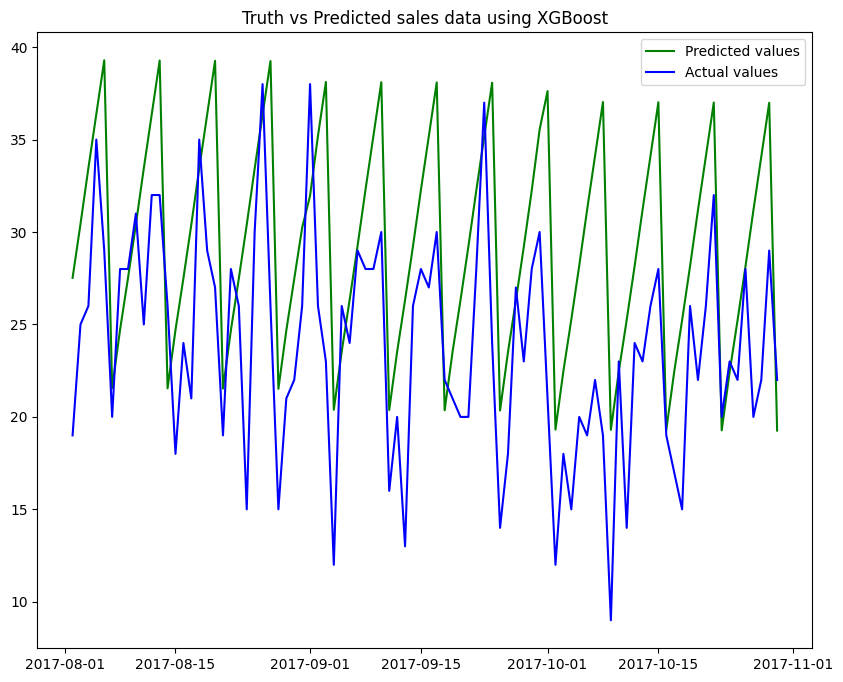

In [ ]:
y_pred_linear_df = pd.DataFrame(model_lr_preds_test)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], model_lr_preds_test[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()

These metrics collectively indicate strong performance of the linear regression model, with low error and high accuracy in predicting sales.


<div class="alert alert-block alert-info"> <b><h3> XGBoost </h3></b> </div>


In [ ]:
#XGBoost Model
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                  ,dtrain=matrix_train,num_boost_round=500,
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model_xgb=XGBmodel(x_train_v2, x_val_v2,y_train_v2,y_val_v2)

[0]	test-mae:16.81372
[1]	test-mae:12.69162
[2]	test-mae:9.99100
[3]	test-mae:8.29578
[4]	test-mae:7.23866
[5]	test-mae:6.62457
[6]	test-mae:6.28586
[7]	test-mae:6.09252
[8]	test-mae:5.98311
[9]	test-mae:5.91552
[10]	test-mae:5.87280
[11]	test-mae:5.84292
[12]	test-mae:5.82204
[13]	test-mae:5.80415
[14]	test-mae:5.78888
[15]	test-mae:5.77462
[16]	test-mae:5.76700
[17]	test-mae:5.75495
[18]	test-mae:5.74605
[19]	test-mae:5.73895
[20]	test-mae:5.73415
[21]	test-mae:5.72789
[22]	test-mae:5.72118
[23]	test-mae:5.71417
[24]	test-mae:5.70835
[25]	test-mae:5.70397
[26]	test-mae:5.69759
[27]	test-mae:5.69441
[28]	test-mae:5.69172
[29]	test-mae:5.68948
[30]	test-mae:5.68589
[31]	test-mae:5.68300
[32]	test-mae:5.67960
[33]	test-mae:5.67650
[34]	test-mae:5.67329
[35]	test-mae:5.67100
[36]	test-mae:5.66906
[37]	test-mae:5.66724
[38]	test-mae:5.66615
[39]	test-mae:5.66442
[40]	test-mae:5.66293
[41]	test-mae:5.66084
[42]	test-mae:5.65943
[43]	test-mae:5.65787
[44]	test-mae:5.65714
[45]	test-mae:5.65

In [ ]:
#model_xgb.save_model("MODEL_XGB.json")

In [ ]:
# Prediction on validation data
model_xgb_valid_pred = model_xgb.predict(xgb.DMatrix(x_val_v2))
# Prediction on test data
model_xgb_preds_test = model_xgb.predict(xgb.DMatrix(x_test_v2))

In [ ]:
#Calculating various error metrics
print('XGBoost validation mse:', mean_squared_error(y_val_v2, model_xgb_valid_pred))
print('XGBoost validation rmse:', np.sqrt(mean_squared_error(y_val_v2, model_xgb_valid_pred)))
print ('XGBoost validation R2 score', r2_score(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAE score', mean_absolute_error(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAPE score', mean_absolute_percentage_error(y_val_v2, model_xgb_valid_pred))

XGBoost validation mse: 53.901159814131894
XGBoost validation rmse: 7.341740925293666
XGBoost validation R2 score 0.9341495138807423
XGBoost validation MAE score 5.634787736472012
XGBoost validation MAPE score 247946228512.53098


In [ ]:
print('XGBoost test mse:', mean_squared_error(y_test_v2, model_xgb_preds_test))
print('XGBoost test rmse:', np.sqrt(mean_squared_error(y_test_v2, model_xgb_preds_test)))
print ('XGBoost test R2 score', r2_score(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAE score', mean_absolute_error(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAPE score', mean_absolute_percentage_error(y_test_v2, model_xgb_preds_test))

XGBoost test mse: 62.673419385957786
XGBoost test rmse: 7.916654557700354
XGBoost test R2 score 0.9316701314638306
XGBoost test MAE score 6.088098846222225
XGBoost test MAPE score 0.12465065208244505


In [ ]:
y_pred_xgb = model_xgb.predict(xgb.DMatrix(x_test_v2))

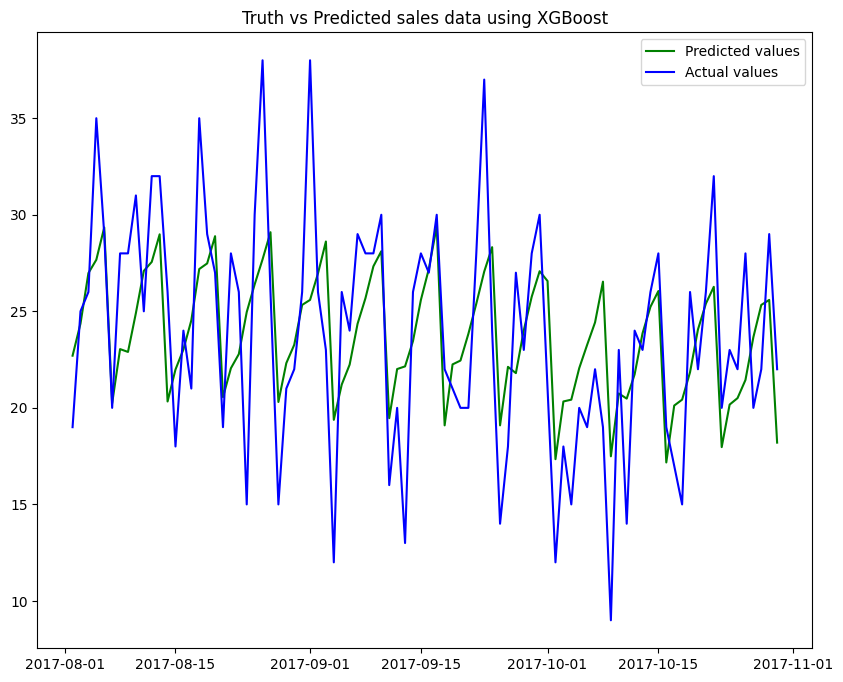

In [ ]:
#plotting Truth vs Predicted sales data - XGBoost
y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], y_pred_xgb[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()

These metrics suggest that the XGBoost model performs even better than the linear regression model, with lower errors and higher accuracy in predicting sales

<div class="alert alert-block alert-info"> <b><h1>Deep Learning Models</h1></b> </div>

<div class="alert alert-block alert-info"> <b><h1>CNN</h1></b> </div>

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape [samples, timesteps, features].

#### Data preprocess
* Reshape into [samples, timesteps, features].
* This same reshaped data will be used on the CNN, LSTM, CNN+LSTM, GRU model.

In [ ]:
x_train_v2.shape

(669200, 42)

In [ ]:
#reshaping data into [samples,features,timesteps]
#data to be used for CNN, LSTM, CNN+LSTM and GRU Models
x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
x_val_series_v2 = x_val_v2.values.reshape((x_val_v2.shape[0], x_val_v2.shape[1], 1))
print('Train set shape', x_train_series_v2.shape)
print('Validation set shape', x_val_series_v2.shape)

Train set shape (669200, 42, 1)
Validation set shape (167300, 42, 1)


In [ ]:
#Setting model parameters
epochs = 10
batch = 128
lr = 0.003
adam = optimizers.Adam(lr)

In [ ]:
#CNN Model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 41, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 20, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                64050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 64293 (251.14 KB)
Trainable params: 64293 (251.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Fit the model on the training data with early stopping
cnn_history = model_cnn.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2),
                             epochs=epochs, verbose=2, callbacks=[early_stopping])

Epoch 1/10
20913/20913 - 112s - loss: 71.6933 - mse: 71.6933 - mae: 6.4410 - mape: 15.5333 - val_loss: 61.1111 - val_mse: 61.1111 - val_mae: 5.9766 - val_mape: 61261.2070 - 112s/epoch - 5ms/step
Epoch 2/10
20913/20913 - 103s - loss: 62.1899 - mse: 62.1899 - mae: 6.0423 - mape: 14.4199 - val_loss: 60.5744 - val_mse: 60.5744 - val_mae: 5.9504 - val_mape: 51864.9453 - 103s/epoch - 5ms/step
Epoch 3/10
20913/20913 - 118s - loss: 61.0605 - mse: 61.0605 - mae: 5.9920 - mape: 14.2934 - val_loss: 59.9088 - val_mse: 59.9088 - val_mae: 5.9484 - val_mape: 64114.9922 - 118s/epoch - 6ms/step
Epoch 4/10
20913/20913 - 96s - loss: 60.4707 - mse: 60.4707 - mae: 5.9642 - mape: 14.2212 - val_loss: 62.2283 - val_mse: 62.2283 - val_mae: 6.0540 - val_mape: 54423.0469 - 96s/epoch - 5ms/step
Epoch 5/10
20913/20913 - 112s - loss: 59.9662 - mse: 59.9662 - mae: 5.9386 - mape: 14.1608 - val_loss: 59.0650 - val_mse: 59.0650 - val_mae: 5.8895 - val_mape: 61007.4766 - 112s/epoch - 5ms/step
Epoch 6/10
20913/20913 - 11

In [ ]:
model_cnn.save("CNN_MODEL.h5")

In [ ]:
#predicting on test data
from keras.models import load_model

# Load the saved model
model_cnn = load_model('/content/drive/MyDrive/CNN_MODEL.h5')

# Assuming x_test_v2 contains your test data
# Make predictions on the test data
y_pred_cnn = model_cnn.predict(x_test_v2)

2375/2375 [==============================] - 5s 2ms/step


In [ ]:
#CNN
print('CNN test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_cnn)))
print ('CNN test R2 score', r2_score(y_test_v2, y_pred_cnn))
print('CNN test MAE:', mean_absolute_error(y_test_v2, y_pred_cnn))
print ('CNN test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_cnn))
print ('CNN test MSE score', mean_squared_error(y_test_v2, y_pred_cnn))

CNN test rmse: 8.476168303125776
CNN test R2 score 0.9216703225446365
CNN test MAE: 6.463877360619997
CNN test MAPE score 0.12854889266857325
CNN test MSE score 71.84542910291411


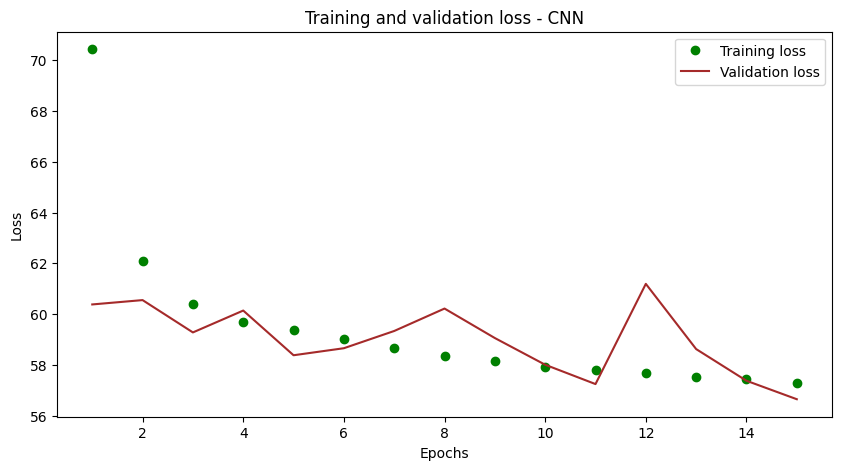

In [ ]:
#plotting trainig and validation loss
import matplotlib.pyplot as plt

cnn_mse = cnn_history.history['mse']
cnn_val_mse = cnn_history.history['val_mse']
cnn_loss = cnn_history.history['loss']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[:], cnn_loss[:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[:], cnn_val_loss[:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

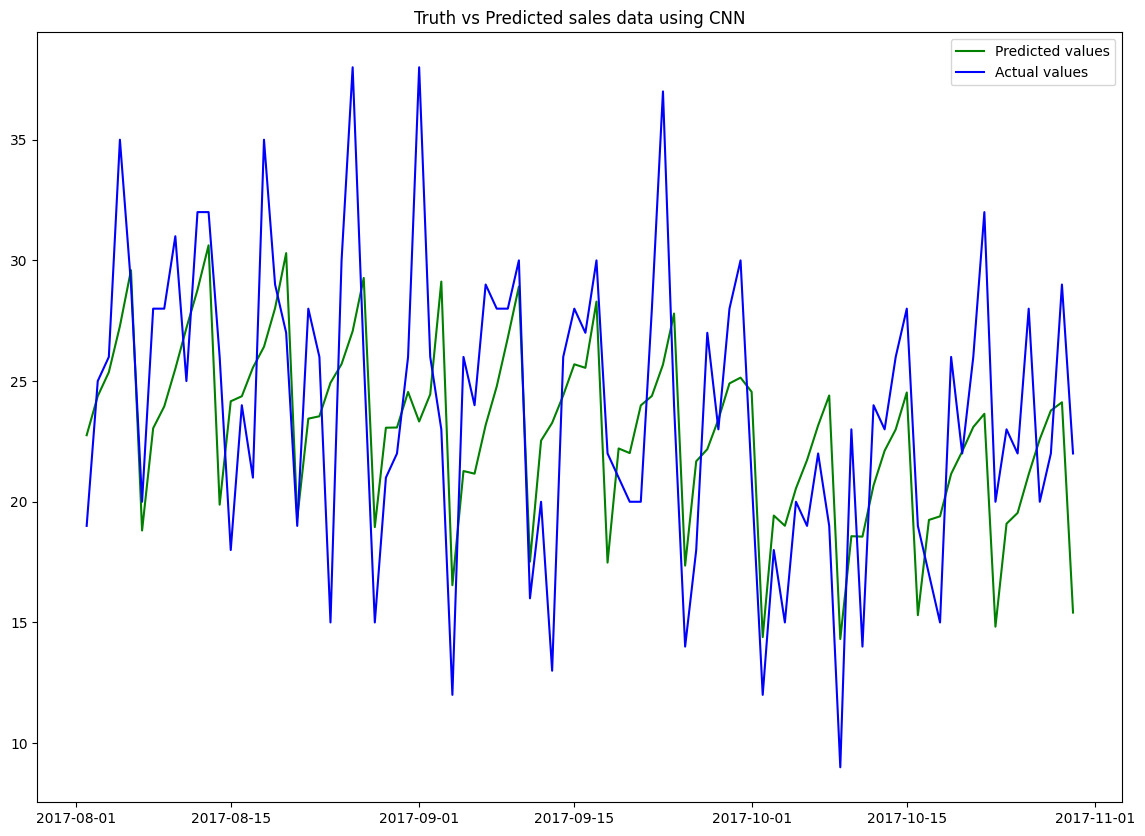

In [ ]:
#plotting truth v/s predicted sales data using CNN model
y_pred_cnn_df = pd.DataFrame(y_pred_cnn)
plt.figure(figsize=(14, 10))

plt.plot(y_date[:90], y_pred_cnn[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using CNN')
plt.legend()

plt.show()

These metrics suggest that the CNN model performs well in predicting sales, with relatively low errors and high accuracy, though not as high as the XGBoost model in terms of R2 score.

<div class="alert alert-block alert-info"> <b><h3>LSTM</h3></b> </div>

In [ ]:
#LSTM model configuration
model_lstm = Sequential()
model_lstm.add(LSTM(42, activation='sigmoid', input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mse',  'mape'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 42)                7392      
                                                                 
 dense_5 (Dense)             (None, 1)                 43        
                                                                 
Total params: 7435 (29.04 KB)
Trainable params: 7435 (29.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#fitting model on training data
lstm_history = model_lstm.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2), epochs=20, batch_size=128, verbose=2)


Epoch 1/20
5229/5229 - 215s - loss: 548.2554 - mae: 13.8925 - mse: 548.2554 - mape: 26.3771 - val_loss: 80.2452 - val_mae: 6.7000 - val_mse: 80.2452 - val_mape: 83947.6641 - 215s/epoch - 41ms/step
Epoch 2/20
5229/5229 - 193s - loss: 64.7777 - mae: 6.1333 - mse: 64.7777 - mape: 14.7584 - val_loss: 74.5381 - val_mae: 6.5851 - val_mse: 74.5381 - val_mape: 79308.5469 - 193s/epoch - 37ms/step
Epoch 3/20
5229/5229 - 210s - loss: 61.6216 - mae: 6.0072 - mse: 61.6216 - mape: 14.4097 - val_loss: 63.4409 - val_mae: 6.0614 - val_mse: 63.4409 - val_mape: 74707.0781 - 210s/epoch - 40ms/step
Epoch 4/20
5229/5229 - 212s - loss: 60.4623 - mae: 5.9559 - mse: 60.4623 - mape: 14.2519 - val_loss: 60.3951 - val_mae: 5.9519 - val_mse: 60.3951 - val_mape: 70300.1875 - 212s/epoch - 40ms/step
Epoch 5/20
5229/5229 - 190s - loss: 59.7944 - mae: 5.9243 - mse: 59.7944 - mape: 14.1713 - val_loss: 67.4884 - val_mae: 6.3436 - val_mse: 67.4884 - val_mape: 70602.2266 - 190s/epoch - 36ms/step
Epoch 6/20
5229/5229 - 225s

In [ ]:
#model_lstm.save("LSTM_MODEL.h5")

In [ ]:
from keras.models import load_model

# Load the saved LSTM model
model_lstm = load_model('/content/drive/MyDrive/LSTM_MODEL.h5')

# Assuming x_test_v2 contains your test data
# Make predictions on the test data
y_pred_lstm = model_lstm.predict(x_test_v2)

2375/2375 [==============================] - 22s 9ms/step


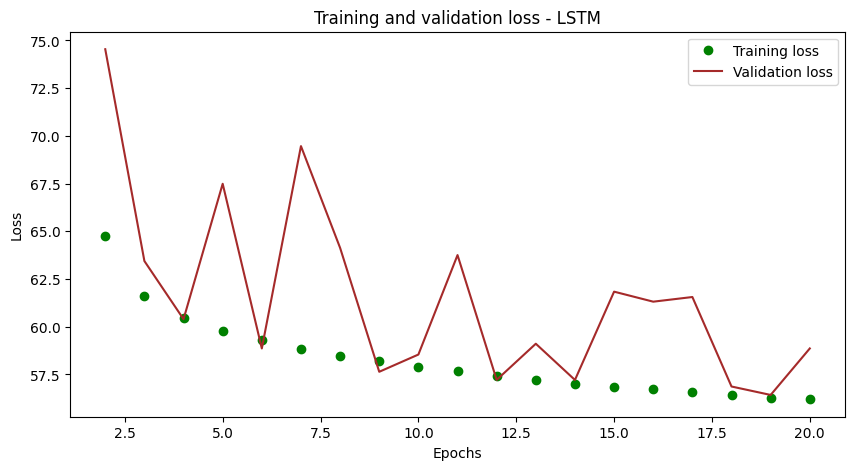

In [ ]:
#plotting training and validation loss using LSTM
import matplotlib.pyplot as plt

mse = lstm_history.history['mse']
val_mse = lstm_history.history['val_mse']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


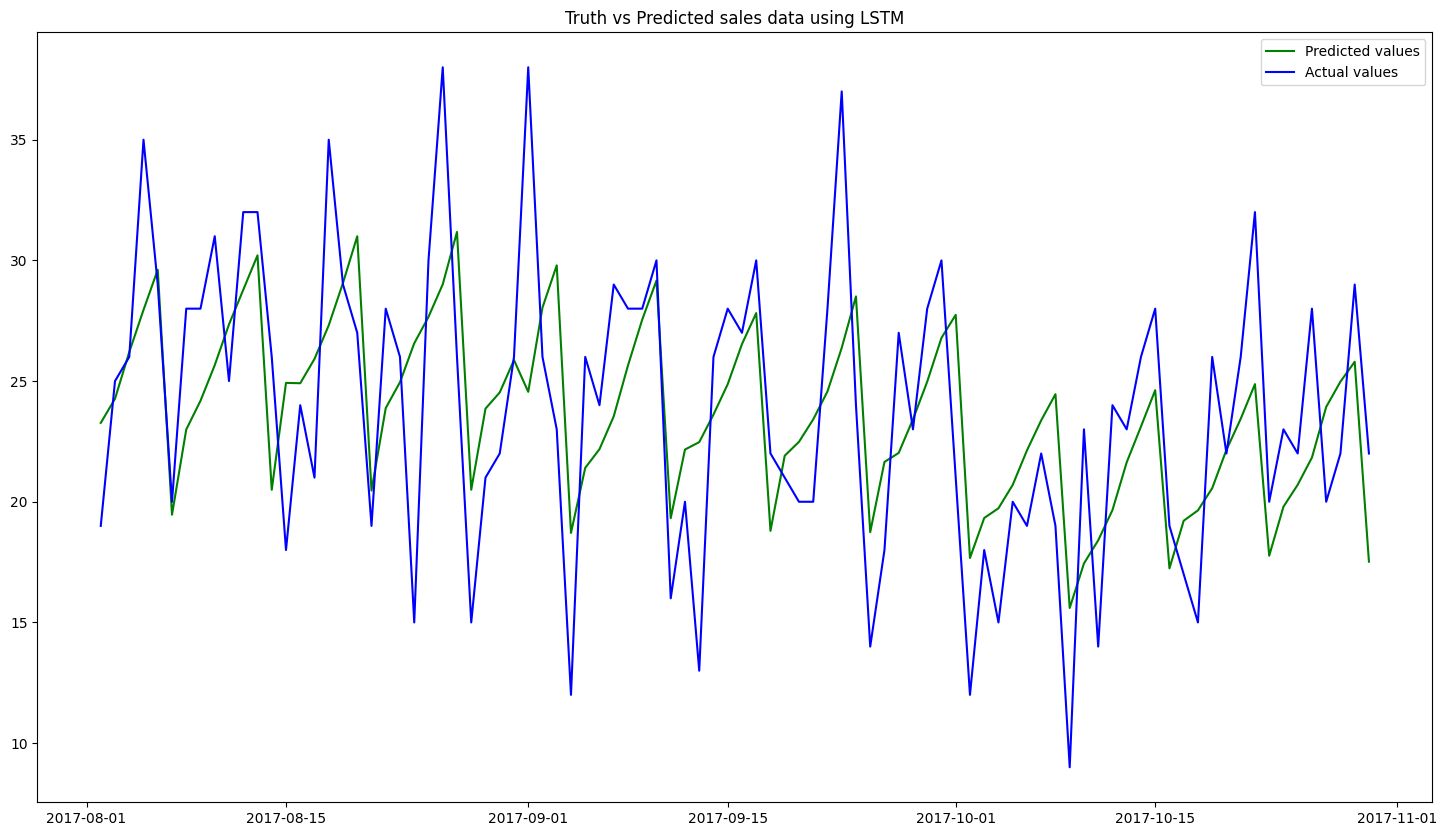

In [ ]:
#plotting graph: Truth v/s predicted sales data using LSTM
y_pred_lstm_df = pd.DataFrame(y_pred_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using LSTM')
plt.legend()

plt.show()

In [ ]:
#LSTM
print('LSTM test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_lstm)))
print ('LSTM test R2 score', r2_score(y_test_v2, y_pred_lstm))
print('LSTM test MAE:', mean_absolute_error(y_test_v2, y_pred_lstm))
print ('LSTM test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_lstm))
print ('LSTM test MSE score', mean_squared_error(y_test_v2, y_pred_lstm))

LSTM test rmse: 8.455392748767837
LSTM test R2 score 0.9220538326545753
LSTM test MAE: 6.4247254801800375
LSTM test MAPE score 0.1276559355283455
LSTM test MSE score 71.49366653591572


These metrics indicate that the LSTM model performs similarly to the CNN model, with relatively low errors and high accuracy in predicting sales.

<div class="alert alert-block alert-info"> <b><h3>GRU</h3></b> </div>

In [ ]:
#GRU model configuration
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam',metrics=['mse', 'mae', 'mape'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 42, 75)            17550     
                                                                 
 gru_1 (GRU)                 (None, 42, 30)            9630      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 32791 (128.09 KB)
Trainable params: 32791 (128.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#fitting model on training data
gru_history = model_gru.fit(x_train_series_v2, y_train_v2, epochs=20, batch_size=64, validation_data=(x_val_series_v2, y_val), shuffle=False)


Epoch 1/20
10457/10457 [==============================] - 130s 12ms/step - loss: 12.8353 - mse: 451.4321 - mae: 12.8353 - mape: 27.1634 - val_loss: 6.0171 - val_mse: 66.0909 - val_mae: 6.0171 - val_mape: 63011.7344
Epoch 2/20
10457/10457 [==============================] - 129s 12ms/step - loss: 5.9218 - mse: 61.5252 - mae: 5.9218 - mape: 13.8838 - val_loss: 5.7824 - val_mse: 57.9996 - val_mae: 5.7824 - val_mape: 60488.5859
Epoch 3/20
10457/10457 [==============================] - 131s 12ms/step - loss: 5.8061 - mse: 57.8653 - mae: 5.8061 - mape: 13.6935 - val_loss: 5.7817 - val_mse: 57.5611 - val_mae: 5.7817 - val_mape: 61215.0273
Epoch 4/20
10457/10457 [==============================] - 119s 11ms/step - loss: 5.7689 - mse: 56.8087 - mae: 5.7689 - mape: 13.6240 - val_loss: 5.7587 - val_mse: 56.9809 - val_mae: 5.7587 - val_mape: 60712.1562
Epoch 5/20
10457/10457 [==============================] - 119s 11ms/step - loss: 5.7502 - mse: 56.3210 - mae: 5.7502 - mape: 13.5906 - val_loss: 5.74

In [ ]:
model_gru.save("/content/drive/MyDrive/GRU_MODEL.h5")

In [ ]:
#predicting on test data
y_pred_gru = model_gru.predict(x_test_v2)

2375/2375 [==============================] - 11s 4ms/step


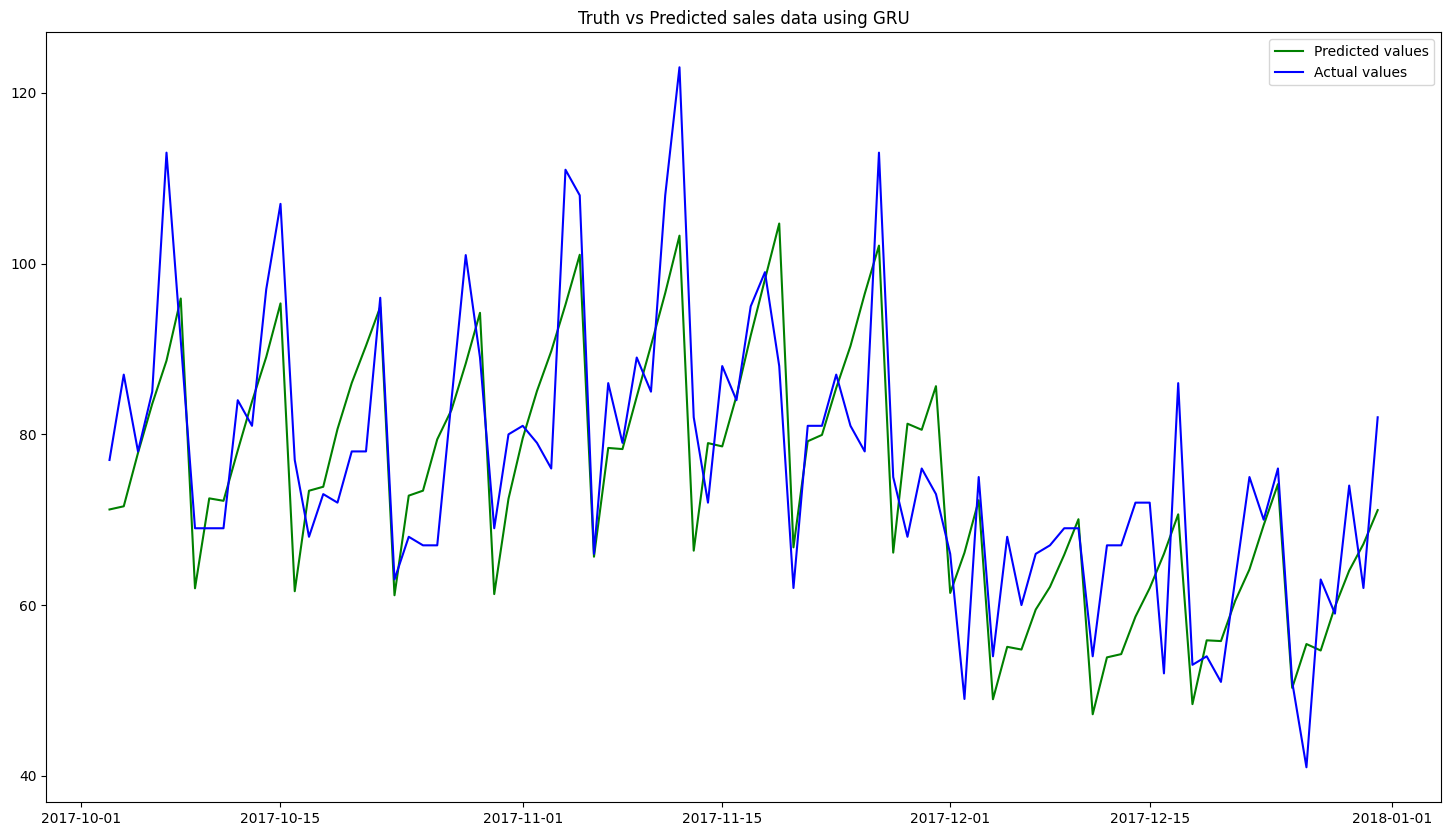

In [ ]:
#plotting truth v/s sales data using GRU
y_pred_gru_df = pd.DataFrame(y_pred_gru)
plt.figure(figsize=(18, 10))

plt.plot(y_date[75910:], y_pred_gru[75910:], 'b', color='green', label='Predicted values')
plt.plot(y_date[75910:], y_test_v2[75910:], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using GRU')
plt.legend()

plt.show()

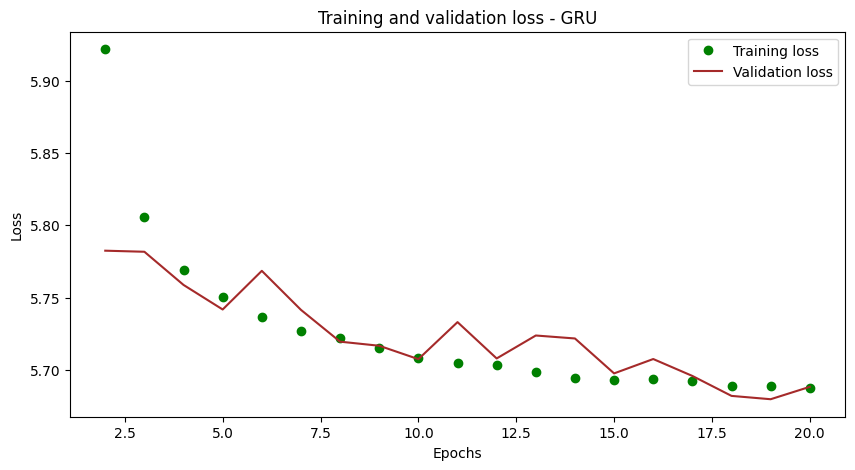

In [ ]:
#plotting training and validation loss using GRU
import matplotlib.pyplot as plt

mse = gru_history.history['mse']
val_mse = gru_history.history['val_mse']
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Calculating various error metrics for GRU
print ('GRU test R2 score', r2_score(y_test_v2, y_pred_gru))
print('GRU test MAE:', mean_absolute_error(y_test_v2, y_pred_gru))
print ('GRU test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_gru))
print ('GRU test MSE score', mean_squared_error(y_test_v2, y_pred_gru))
print('GRU test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_gru)))

GRU test R2 score 0.929265650666018
GRU test MAE: 6.170674594515249
GRU test MAPE score 0.12275859736442106
GRU test MSE score 64.87885365175075
GRU test rmse: 8.054741066710385


The GRU model exhibits superior predictive accuracy with low errors, notably achieving a high R2 score. Compared to LSTM, CNN, and XGBoost, GRU demonstrates comparable or better performance across key evaluation metrics.

<div class="alert alert-block alert-info"> <b><h3>CNN-LSTM</h3></b> </div>

<b>Description of the model:</B>

The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model.

When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence.

The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction.

In [ ]:
#Model parameters
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
x_train_series_v2.shape

(669200, 42, 1)

In [ ]:
x_val_series_v2.shape

(167300, 42, 1)

In [ ]:
# Reshape input data from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
subsequences = 2
timesteps = x_train_series_v2.shape[1] // subsequences  # Divide the original timesteps into subsequences
features = x_train_series_v2.shape[2]  # Assuming features is the last dimension

# Reshape train set
x_train_series_sub = x_train_series_v2.reshape((x_train_series_v2.shape[0], subsequences, timesteps, features))

# Reshape validation set
x_val_series_sub = x_val_series_v2.reshape((x_val_series_v2.shape[0], subsequences, timesteps, features))

print('Train set shape', x_train_series_sub.shape)
print('Validation set shape', x_val_series_sub.shape)

Train set shape (669200, 2, 21, 1)
Validation set shape (167300, 2, 21, 1)


In [ ]:
#CNN-LSTM model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, x_train_series_sub.shape[2], x_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
#fitting model on training data
cnn_lstm_history = model_cnn_lstm.fit(x_train_series_sub, y_train, validation_data=(x_val_series_sub, y_val), epochs=epochs, verbose=2)

Epoch 1/40
20913/20913 - 150s - loss: 76.2498 - val_loss: 70.3950 - 150s/epoch - 7ms/step
Epoch 2/40
20913/20913 - 138s - loss: 65.6890 - val_loss: 63.6636 - 138s/epoch - 7ms/step
Epoch 3/40
20913/20913 - 147s - loss: 64.5751 - val_loss: 66.3336 - 147s/epoch - 7ms/step
Epoch 4/40
20913/20913 - 137s - loss: 63.9506 - val_loss: 64.3897 - 137s/epoch - 7ms/step
Epoch 5/40
20913/20913 - 148s - loss: 63.5512 - val_loss: 62.7525 - 148s/epoch - 7ms/step
Epoch 6/40
20913/20913 - 138s - loss: 63.0474 - val_loss: 62.0025 - 138s/epoch - 7ms/step
Epoch 7/40
20913/20913 - 147s - loss: 62.6500 - val_loss: 62.6528 - 147s/epoch - 7ms/step
Epoch 8/40
20913/20913 - 148s - loss: 62.2939 - val_loss: 63.8527 - 148s/epoch - 7ms/step
Epoch 9/40
20913/20913 - 148s - loss: 62.3131 - val_loss: 66.8695 - 148s/epoch - 7ms/step
Epoch 10/40
20913/20913 - 146s - loss: 61.9043 - val_loss: 61.1911 - 146s/epoch - 7ms/step
Epoch 11/40
20913/20913 - 136s - loss: 61.6409 - val_loss: 61.0934 - 136s/epoch - 7ms/step
Epoch 12

In [ ]:
#model_cnn_lstm.save("/content/drive/MyDrive/CNN-LSTM_MODEL.h5")

In [ ]:
x_train_series_v2.shape

(669200, 42, 1)

In [ ]:
x_test_v2.shape

x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
subsequences = 2
timesteps = x_train_series_v2.shape[1] // subsequences
x_train_series_sub = x_train_series_v2.reshape((x_train_series_v2.shape[0], subsequences, timesteps, 1))

In [ ]:
#prediction on test data
# Assuming you have loaded or prepared your test data and stored it in the variable x_test_v2
# Reshape the test data to match the input shape expected by the model
import numpy as np

# Convert DataFrame to NumPy array
x_test_v2_array = x_test_v2.values

# Reshape the test data to match the input shape expected by the model
subsequences = 2
timesteps = x_test_v2_array.shape[1] // subsequences
x_test_v2_series_sub = x_test_v2_array.reshape((x_test_v2_array.shape[0], subsequences, timesteps, 1))

# Now you can use x_test_v2_series_sub for prediction
from keras.models import load_model

# Load the saved CNN-LSTM model
model_cnn_lstm = load_model('/content/drive/MyDrive/CNN-LSTM_MODEL.h5')

# Assuming x_test_v2_series_sub contains your test data
# Make predictions on the test data
y_pred_cnn_lstm = model_cnn_lstm.predict(x_test_v2_series_sub)


2375/2375 [==============================] - 11s 4ms/step


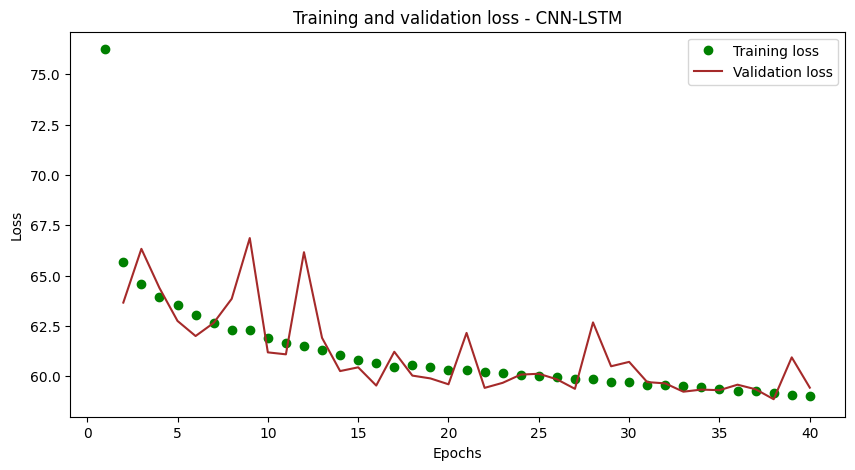

In [ ]:
import matplotlib.pyplot as plt

loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs[:], loss[:], 'bo', color='green', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



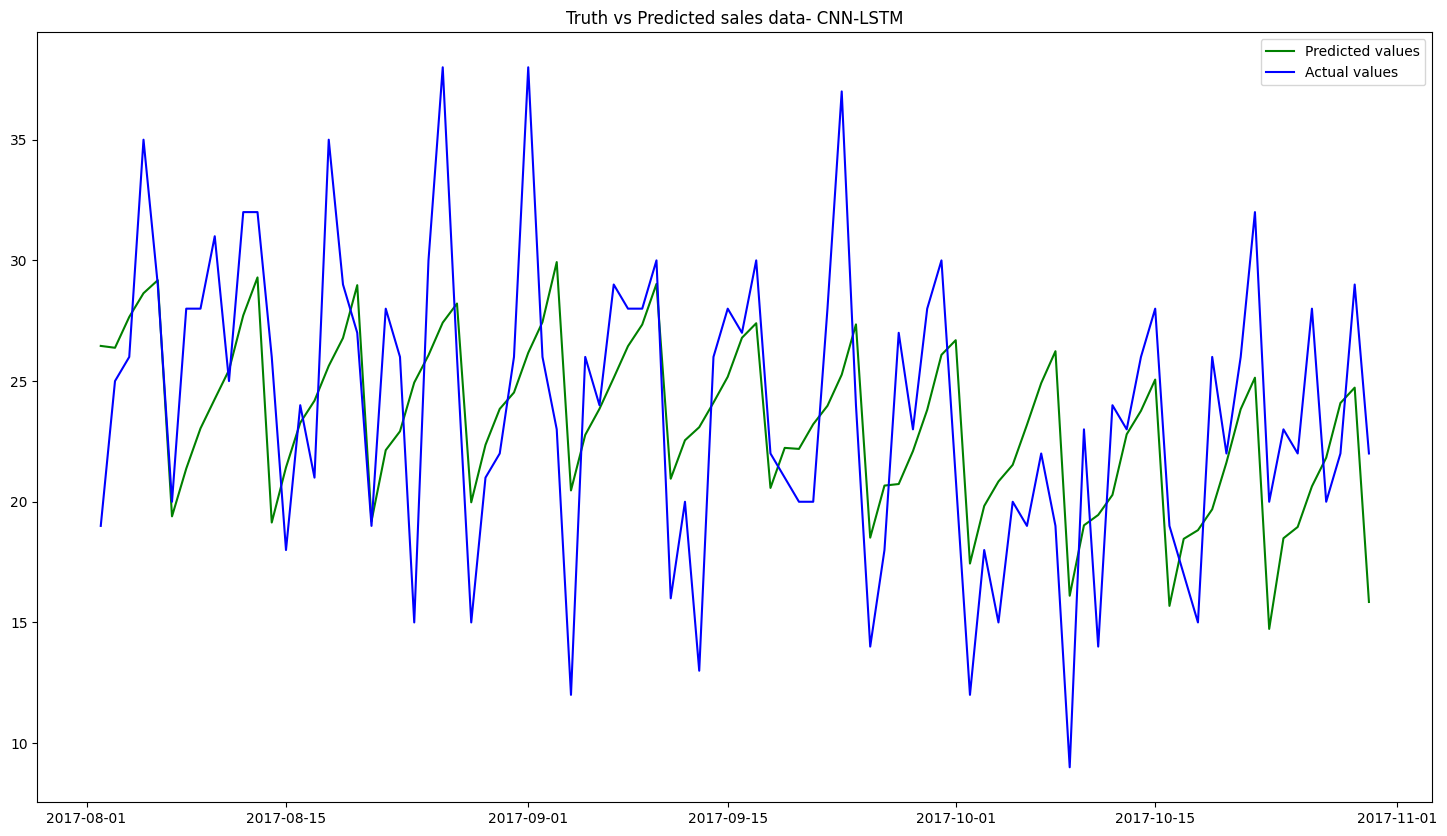

In [ ]:
#plotting truth v/s sales data using CNN-LSTM
y_pred_cnn_lstm_df = pd.DataFrame(y_pred_cnn_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_cnn_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data- CNN-LSTM')
plt.legend()

plt.show()

In [ ]:
print('CNN-LSTM test rmse:', np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm)))
print ('CNN-LSTM test R2 score', r2_score(y_test, y_pred_cnn_lstm))
print('CNN-LSTM test MAE:', mean_absolute_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MAPE score', mean_absolute_percentage_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MSE score', mean_squared_error(y_test, y_pred_cnn_lstm))

CNN-LSTM test rmse: 8.533429726522167
CNN-LSTM test R2 score 0.9206084231207561
CNN-LSTM test MAE: 6.509966909697181
CNN-LSTM test MAPE score 0.13203642998743434
CNN-LSTM test MSE score 72.81942289749217


The CNN-LSTM model combines the strengths of CNN for processing subsequences and LSTM for temporal dependencies, allowing it to handle long input sequences effectively.

 Despite its complexity, the CNN-LSTM model achieves competitive performance, with an RMSE of 8.53, R2 score of 0.921, MAE of 6.51, MAPE of 0.132, and MSE of 72.82.

In conclusion, the demand forecasting project on store sales data employed a range of machine learning and deep learning models, including linear regression, XGBoost, CNN, LSTM, GRU, and CNN-LSTM.

1. The linear regression model achieved moderate performance, with an RMSE of 9.33 and an R2 score of 0.905.
2. XGBoost emerged as the top performer, exhibiting superior predictive accuracy with a lower RMSE of 7.92 and a higher R2 score of 0.932.
3. CNN and LSTM models demonstrated competitive performance, with CNN achieving an RMSE of 8.48 and an R2 score of 0.922, and LSTM achieving similar results with an RMSE of 8.46 and an R2 score of 0.922.
4. The GRU model showcased strong predictive accuracy, with an R2 score of 0.929 and an RMSE of 8.05, indicating its effectiveness in capturing data patterns and making accurate predictions.
5. The CNN-LSTM model, combining CNN and LSTM, achieved competitive performance, with an RMSE of 8.53 and an R2 score of 0.921.


Overall, the XGBoost model emerged as the top performer among the evaluated models, followed closely by the GRU model. These findings underscore the importance of leveraging advanced modeling techniques for accurate demand forecasting in retail settings, facilitating optimized inventory management and effective meeting of customer demands.